### Подключение библиотек

In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader

from zipfile import ZipFile
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import random
import pickle

from tqdm import trange
from time import sleep

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Загрузка изображений

In [3]:
path = "/content/gdrive/MyDrive/trpp_project/new_dataset"
print(os.listdir(path))

['labels.pickle', 'training_data.pickle', 'bt_images']


In [4]:
training_data = pickle.load(open(path + '/training_data.pickle', 'rb'))
random.shuffle(training_data)

In [5]:
total_data_len = len(training_data)
classes = ['Meningioma', 'Glioma', 'Pitutary']
n_classes = len(classes)

x_raw = []
y_raw = []

for features, lebel in training_data:
    x_raw.append(features)
    y_raw.append(lebel)

y_raw = list(np.asarray(y_raw) - np.ones(total_data_len, dtype=np.int8))

### Распределение таргета

In [6]:
pd.Series(np.asarray(y_raw)).value_counts()

1    1426
2     930
0     708
dtype: int64

### Посмотрим на случайные сэмплы

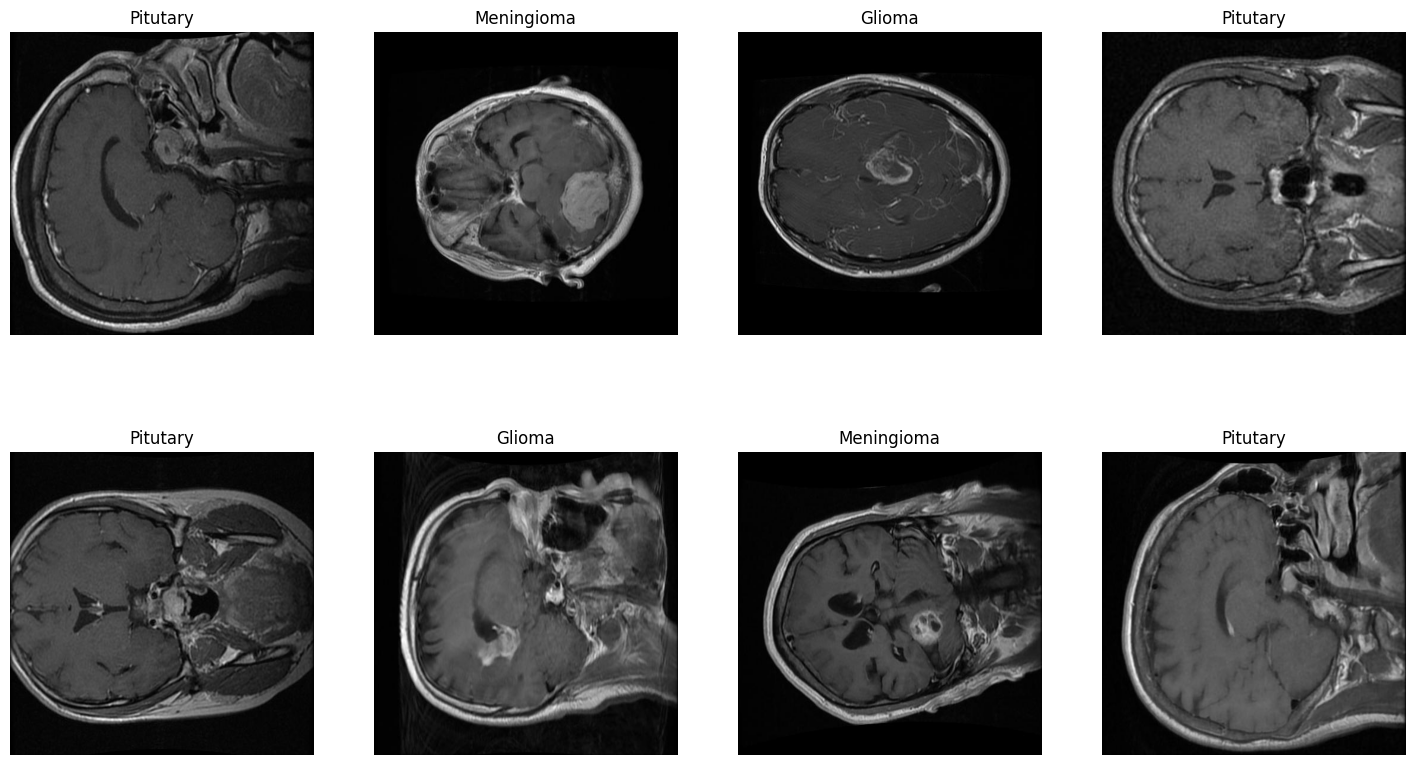

In [7]:
plt.figure(figsize=(18, 10))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.axis("off")
    plt.imshow(x_raw[i])
    plt.title(classes[y_raw[i]])

    plt.subplot(2, 4, i + 5)
    plt.axis("off")
    plt.imshow(x_raw[i + 5])
    plt.title(classes[y_raw[i + 5]])
plt.show();

### Подготовка к обучению

In [8]:
# размер батча
BATCH_SIZE = 4

# treshold для валидации
valid_treshold = 2100

X_train, X_valid = x_raw[:valid_treshold], x_raw[valid_treshold:]
y_train, y_valid = y_raw[:valid_treshold], y_raw[valid_treshold:]

print("\nTrain shape:", len(X_train),
      "\nValid shape:", len(X_valid))


Train shape: 2100 
Valid shape: 964


### Класс BrainTumorDataset

In [9]:
transforms_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(degrees=(-45, 45)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
from BrainTumorDataset import BrainTumorDataset


train_dataset = BrainTumorDataset(X_train, y_train, transform=transforms_train)
validation_dataset = BrainTumorDataset(X_valid, y_valid, transform=transforms_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Размерность Батча:", *next(iter(train_dataloader))[0].shape)

Размерность Батча: 4 3 224 224


### Создание объекта модели

In [11]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=86536b983c5be1b112ae3e79f71b35832dde98458c6e860370661262756b2d9e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [13]:
from EfficientNetModel import EfficientNetModel

model = EfficientNetModel('efficientnet-b1')

Loaded pretrained weights for efficientnet-b1


### Обучение

In [14]:
optimizer = torch.optim.Adagrad(model.model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
history_model = model.train(15, optimizer, loss_fn, train_dataloader, val_dataloader)

CUDA is available!  Training on GPU ...


Progress Bar: 100%|██████████| 15/15 [2:59:25<00:00, 717.68s/carrots]


In [20]:
torch.save(model.model.state_dict(), "my-efficientnet-b1")

### Графики обучения и метрик

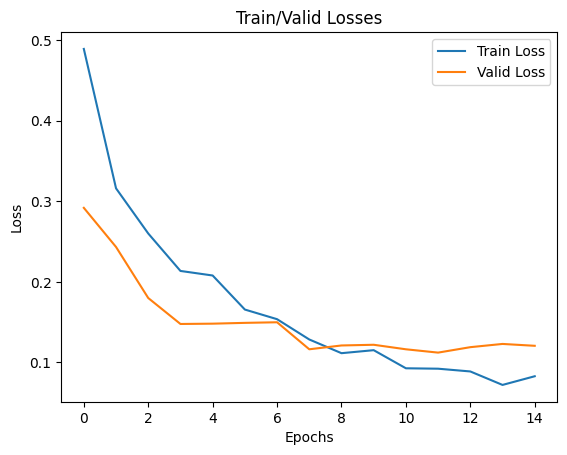

In [21]:
plt.plot(history_model['losses']['train'], label="Train Loss");
plt.plot(history_model['losses']['valid'], label="Valid Loss");
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend();
plt.title("Train/Valid Losses");

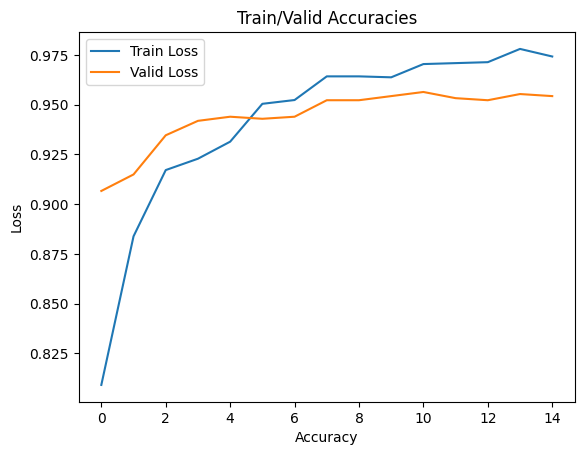

In [22]:
plt.plot(history_model['accuracy']['train'], label="Train Loss");
plt.plot(history_model['accuracy']['valid'], label="Valid Loss");
plt.xlabel("Accuracy");
plt.ylabel("Loss");
plt.legend();
plt.title("Train/Valid Accuracies");